In [169]:
import torch
from replay_buffer import ReplayBuffer
from agent import PD_DDPG
from env import SimpleBuildingEnv
from utils import training_loop, evaluate_consecutive_episodes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ImportError: cannot import name 'evaluate_consecutive_episodes' from 'utils' (/home/alireza/neuromancer/neuromancer/neuromancer_RL/examples/domain_examples/rl_example/utils.py)

<h1 style="font-size: 28px; font-weight: bold;">Building Environment for Temperature Control</h1>

<p style="font-size: 18px;">
This environment models a single-zone building heating problem where the goal is to maintain the indoor temperature within specific reference limits. The action taken by the agent represents the mass flow rate of the heating system, and the agent is rewarded for efficient energy usage while penalized for temperature violations.
</p>

<hr>

<h2 style="font-size: 24px; font-weight: bold;">State Transition Dynamics</h2>
<p style="font-size: 18px;">
The building environment uses a linear state-space model to simulate the indoor temperature dynamics:
</p>

<div style="font-size: 20px; text-align: center;">
$$
x_{t+1} = A x_t + B u_t + E d_t
$$
</div>

<p style="font-size: 18px;">
where:
<ul>
    <li><b>$x_t$</b> represents the system states (e.g., indoor temperature),</li>
    <li><b>$u_t$</b> is the control action (mass flow rate of the heating system),</li>
    <li><b>$d_t$</b> is the external disturbance (e.g., outdoor temperature, solar radiation),</li>
    <li><b>$A$, $B$, $E$</b> are system matrices defining the dynamics.</li>
</ul>
</p>

<p style="font-size: 18px;">
The output equation is:
</p>

<div style="font-size: 20px; text-align: center;">
$$
y_t = C x_t
$$
</div>

<p style="font-size: 18px;">
where <b>$y_t$</b> is the measured indoor temperature to be controlled.
</p>

<hr>

<h2 style="font-size: 24px; font-weight: bold;">Action Space</h2>
<p style="font-size: 18px;">
The action taken by the agent is the normalized mass flow rate <b>$u_t$</b>, represented as a scalar within the range:
</p>

<div style="font-size: 20px; text-align: center;">
$$
u_t \in [0, 1]
$$
</div>

<p style="font-size: 18px;">
The environment scales the action to the maximum allowable mass flow rate <b>$U_{\text{max}}$</b>.
</p>

<hr>

<h2 style="font-size: 24px; font-weight: bold;">Observation Space</h2>
<p style="font-size: 18px;">
The state observed by the agent includes:
</p>
<ol style="font-size: 18px;">
    <li>The system states <b>$x_t$</b>,</li>
    <li>The current disturbance <b>$d_t$</b>,</li>
    <li>The reference temperature limits <b>$[T_{\text{min}}, T_{\text{max}}]$</b>.</li>
</ol>
<p style="font-size: 18px;">
These features are normalized using precomputed mean and standard deviation values to ensure stable training.
</p>

<hr>

<h2 style="font-size: 24px; font-weight: bold;">Reward Function</h2>
<p style="font-size: 18px;">
The reward is designed to penalize excessive energy use. It is calculated as:
</p>

<div style="font-size: 20px; text-align: center;">
$$
r_t = - (u_t \cdot 0.01 \cdot U_{\text{max}})
$$
</div>

<p style="font-size: 18px;">
where:
<ul>
    <li><b>$u_t$</b> is the normalized action taken by the agent,</li>
    <li><b>$U_{\text{max}}$</b> is the maximum allowable mass flow rate.</li>
</ul>
</p>

<p style="font-size: 18px;">
This encourages the agent to minimize energy usage.
</p>

<hr>

<h2 style="font-size: 24px; font-weight: bold;">Cost Function</h2>
<p style="font-size: 18px;">
The cost penalizes the agent for violating the reference temperature limits. It is defined as:
</p>

<div style="font-size: 20px; text-align: center;">
$$
c_t = 50 \cdot \left( \max(T_{\text{min}} - y_t, 0) + \max(y_t - T_{\text{max}}, 0) \right)
$$
</div>

<p style="font-size: 18px;">
where:
<ul>
    <li><b>$T_{\text{min}}$</b> and <b>$T_{\text{max}}$</b> are the reference temperature bounds,</li>
    <li><b>$y_t$</b> is the current indoor temperature.</li>
</ul>
</p>

<p style="font-size: 18px;">
This ensures the agent prioritizes keeping the temperature within acceptable limits.
</p>

<hr>

<h2 style="font-size: 24px; font-weight: bold;">Reference Temperature Bounds</h2>
<p style="font-size: 18px;">
The temperature bounds are dynamically updated at each reset:
</p>

<div style="font-size: 20px; text-align: center;">
$$
T_{\text{min}} = T_{\text{default, min}} + \text{random offset}
$$

$$
T_{\text{max}} = T_{\text{min}} + 2.0
$$
</div>

<p style="font-size: 18px;">
This variation introduces stochasticity to improve the robustness of the learned policy.
</p>

<hr>

<h2 style="font-size: 24px; font-weight: bold;">Disturbance Generation</h2>
<p style="font-size: 18px;">
The disturbances <b>$d_t$</b>, such as outdoor temperature and solar radiation, are generated as a trajectory over the episode length. These are used to simulate realistic external conditions affecting the indoor temperature dynamics.
</p>

<hr>

<h2 style="font-size: 24px; font-weight: bold;">Episode and Normalization</h2>
<ul style="font-size: 18px;">
    <li>The environment runs for a fixed number of timesteps <b>$T = 5000$</b>.</li>
    <li>States are normalized based on precomputed means and standard deviations over multiple random trajectories, ensuring consistent scaling during training.</li>
</ul>


In [164]:
# Initialize the environment
env = SimpleBuildingEnv(simulator=None, random_seed=10, min_temp=18, max_temp=22, timesteps=1000)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = env.action_space.high[0]

# Initialize replay buffer
replay_buffer = ReplayBuffer(1e5)


/home/alireza/anaconda3/envs/neuromancer/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


<h1 style="font-size: 28px; font-weight: bold;">Primal-Dual Deep Deterministic Policy Gradient (PD-DDPG)</h1>

<p style="font-size: 18px;">
PD-DDPG is a reinforcement learning algorithm designed to handle Constrained Markov Decision Processes (CMDPs). In this implementation, the problem is continuous, meaning that episodes have no defined termination, and the discount factor <b>$\gamma$</b> is set to 0. Consequently, the algorithm directly optimizes for immediate rewards and costs. Below are the key mathematical foundations and modifications for this continuous setup.
</p>

<hr>

<h2 style="font-size: 24px; font-weight: bold;">State Transition Dynamics</h2>
<p style="font-size: 18px;">
The environment follows the Markov Decision Process (MDP) dynamics:
</p>

<div style="font-size: 20px; text-align: center;">
$$
s_{t+1} = f(s_t, a_t) + \epsilon_t
$$
</div>

<p style="font-size: 18px;">
where:
<ul>
    <li><b>$s_t$</b> is the state at time <b>$t$</b>,</li>
    <li><b>$a_t$</b> is the action taken,</li>
    <li><b>$f$</b> is the transition function, and</li>
    <li><b>$\epsilon_t$</b> is noise.</li>
</ul>
</p>

<hr>

<h2 style="font-size: 24px; font-weight: bold;">Dual Objective (Lagrangian Function)</h2>
<p style="font-size: 18px;">
The algorithm optimizes the following Lagrangian:
</p>

<div style="font-size: 20px; text-align: center;">
$$
\mathcal{L}(\pi, \lambda) = \mathbb{E}_{\pi} \left[ r(s_t, a_t) - \lambda \cdot c(s_t, a_t) \right]
$$
</div>

<p style="font-size: 18px;">
Here:
<ul>
    <li><b>$r(s_t, a_t)$</b> is the immediate reward,</li>
    <li><b>$c(s_t, a_t)$</b> is the immediate cost,</li>
    <li><b>$\lambda$</b> is the dual variable that balances reward and cost, and</li>
    <li><b>$\pi(a_t | s_t)$</b> is the policy.</li>
</ul>
</p>

<hr>

<h2 style="font-size: 24px; font-weight: bold;">Critic and Cost Networks</h2>
<ul style="font-size: 18px;">
    <li><b>Critic Network</b>: The Q-value network estimates the immediate reward:
        <div style="font-size: 20px; text-align: center;">
        $$
        Q(s_t, a_t) = r(s_t, a_t)
        $$
        </div>
    </li>
    <li><b>Cost Network</b>: The cost network directly estimates the immediate cost:
        <div style="font-size: 20px; text-align: center;">
        $$
        C(s_t, a_t) = c(s_t, a_t)
        $$
        </div>
    </li>
</ul>

<p style="font-size: 18px;">
Since <b>$\gamma = 0$</b>, the loss functions for the critic and cost networks are simplified to:
</p>

<div style="font-size: 20px; text-align: center;">
$$
\mathcal{L}_{\text{critic}} = \mathbb{E} \left[ \left( Q(s_t, a_t) - r(s_t, a_t) \right)^2 \right]
$$
$$
\mathcal{L}_{\text{cost}} = \mathbb{E} \left[ \left( C(s_t, a_t) - c(s_t, a_t) \right)^2 \right]
$$
</div>

<hr>

<h2 style="font-size: 24px; font-weight: bold;">Actor Network Update</h2>
<p style="font-size: 18px;">
The actor network is updated to:
</p>
<ol style="font-size: 18px;">
    <li>Maximize Reward (<b>$Q(s_t, a_t)$</b>),</li>
    <li>Minimize Cost (<b>$C(s_t, a_t)$</b>), and</li>
    <li>Ensure Smooth Actions (minimize changes between consecutive actions).</li>
</ol>

<p style="font-size: 18px;">
The actor's loss function is given by:
</p>

<div style="font-size: 20px; text-align: center;">
$$
\mathcal{L}_{\text{actor}} = -\mathbb{E} \left[ Q(s_t, a_t) - \lambda \cdot C(s_t, a_t) \right] + \beta \cdot \| a_t - a_{t+1} \|^2
$$
</div>

<p style="font-size: 18px;">
Here:
<ul>
    <li><b>$\lambda$</b> adjusts the trade-off between maximizing rewards and minimizing costs,</li>
    <li><b>$\| a_t - a_{t+1} \|^2$</b> ensures smoother actions by penalizing large changes, and</li>
    <li><b>$\beta$</b> is a weighting factor for the smoothness term.</li>
</ul>
</p>

<hr>

<h2 style="font-size: 24px; font-weight: bold;">Dual Variable Update</h2>
<p style="font-size: 18px;">
The dual variable <b>$\lambda$</b> is updated dynamically based on the current cost violation:
</p>

<div style="font-size: 20px; text-align: center;">
$$
\lambda \leftarrow \max(0, \lambda + \alpha \cdot (C(s_t, a_t) - \text{constraint\_limit}))
$$
</div>

<p style="font-size: 18px;">
where:
<ul>
    <li><b>$\alpha$</b> is the step size for <b>$\lambda$</b>,</li>
    <li><b>$C(s_t, a_t)$</b> is the immediate cost, and</li>
    <li><b>$\text{constraint\_limit}$</b> is the acceptable cost threshold.</li>
</ul>
</p>

<p style="font-size: 18px;">
This ensures that <b>$\lambda$</b> increases when constraints are violated, prioritizing cost minimization, and decreases when the policy adheres to constraints.
</p>

<hr>

<h2 style="font-size: 24px; font-weight: bold;">Target Network Soft Updates</h2>
<p style="font-size: 18px;">
The target networks for the critic, cost, and actor are updated using soft updates for stability:
</p>

<div style="font-size: 20px; text-align: center;">
$$
\theta_{\text{target}} \leftarrow \tau \theta_{\text{online}} + (1 - \tau) \theta_{\text{target}}
$$
</div>

<p style="font-size: 18px;">
where:
<ul>
    <li><b>$\tau \in [0, 1]$</b> is the soft update coefficient.</li>
</ul>
</p>


### Actor Loss Update in PD-DDPG

The actor network in PD-DDPG is updated using a loss function that balances maximizing rewards, minimizing costs, and ensuring consistency between consecutive actions. The actor loss is defined as:

$$
\mathcal{L}_{\text{actor}} = -\mathbb{E} \left[ Q(s_t, a_t) - \lambda \cdot C(s_t, a_t) \right] + \text{MSE}(a_t, a_t^{\text{target}})
$$

where:
- $Q(s_t, a_t)$: Immediate reward estimated by the critic network.
- $C(s_t, a_t)$: Immediate cost estimated by the cost network.
- $\lambda$: Dual variable balancing the trade-off between rewards and costs.
- $\text{MSE}(a_t, a_t^{\text{target}})$: Mean squared error between the current action and the target action to ensure smoothness.

In the code, the loss is implemented as:

```python
actor_loss = -(Q_value - self.lambda_.detach() * C_value).mean() + nn.MSELoss()(self.actor(state), self.actor_target(next_state))


In [ ]:
# Initialize agent parameters
lambda_ = 1.
lambda_step = 5e-6
constraint_limit = 0.05 * 50.
lr_critic = 1e-3
lr_actor = 1e-4
hidden_layers = [128, 128]
iterations = 300
policy_freq = 2
discount = 0.0

# Initialize agent
agent = PD_DDPG(state_dim, action_dim, max_action, lambda_, lambda_step, constraint_limit, lr_critic, lr_actor, hidden_layers)


In [ ]:
# Initialize training loop parameters
num_steps = 2e5
expl_steps = 1e4
batch_size = 128
expl_noise = 0.3
total_ts = 0

In [ ]:
#starting training process:
eval_reward_hist, eval_cost_hist = training_loop(env, agent, replay_buffer, expl_steps, expl_noise, batch_size, num_steps, iterations, discount, policy_freq)

In [ ]:
# Evaluate in consecutive episodes

horizon = 2000
min_temp = 18.0
max_temp = 22.0
eval_env = SimpleBuildingEnv(simulator=None, random_seed=10, min_temp=18, max_temp=22, timesteps=horizon)

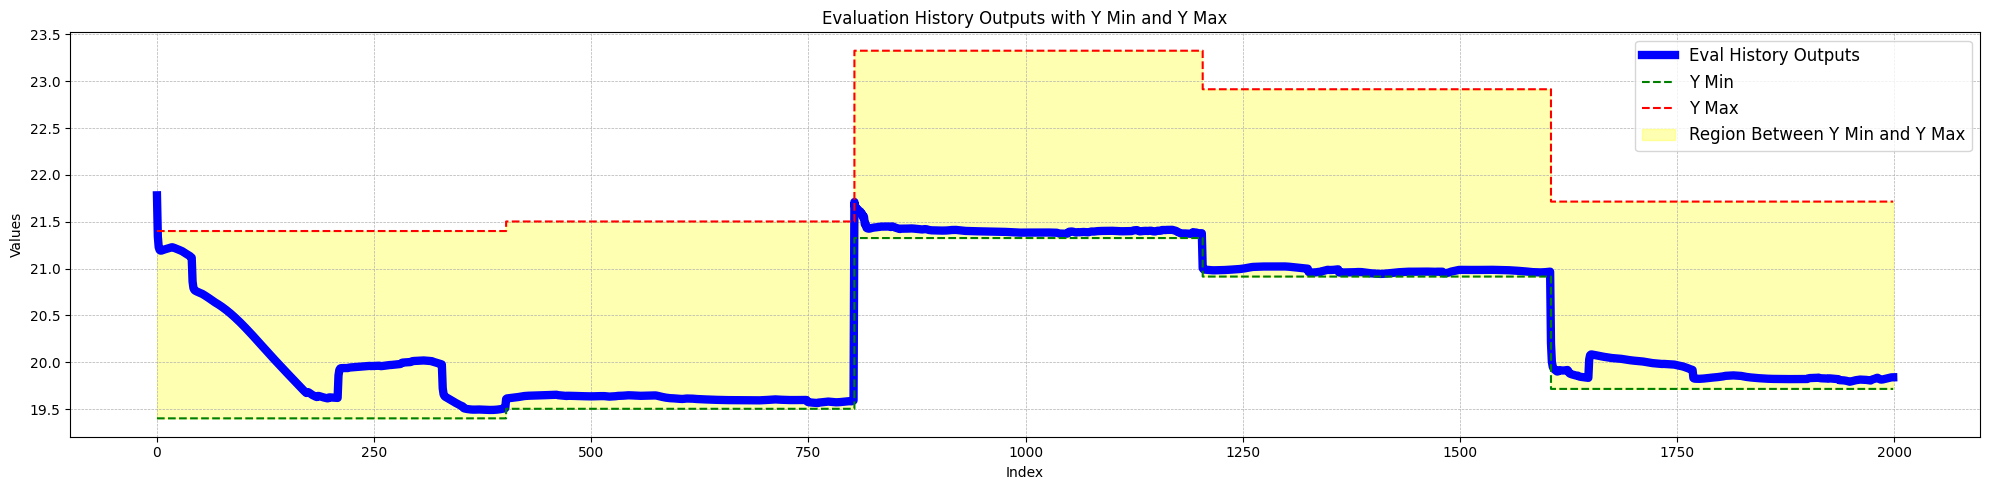

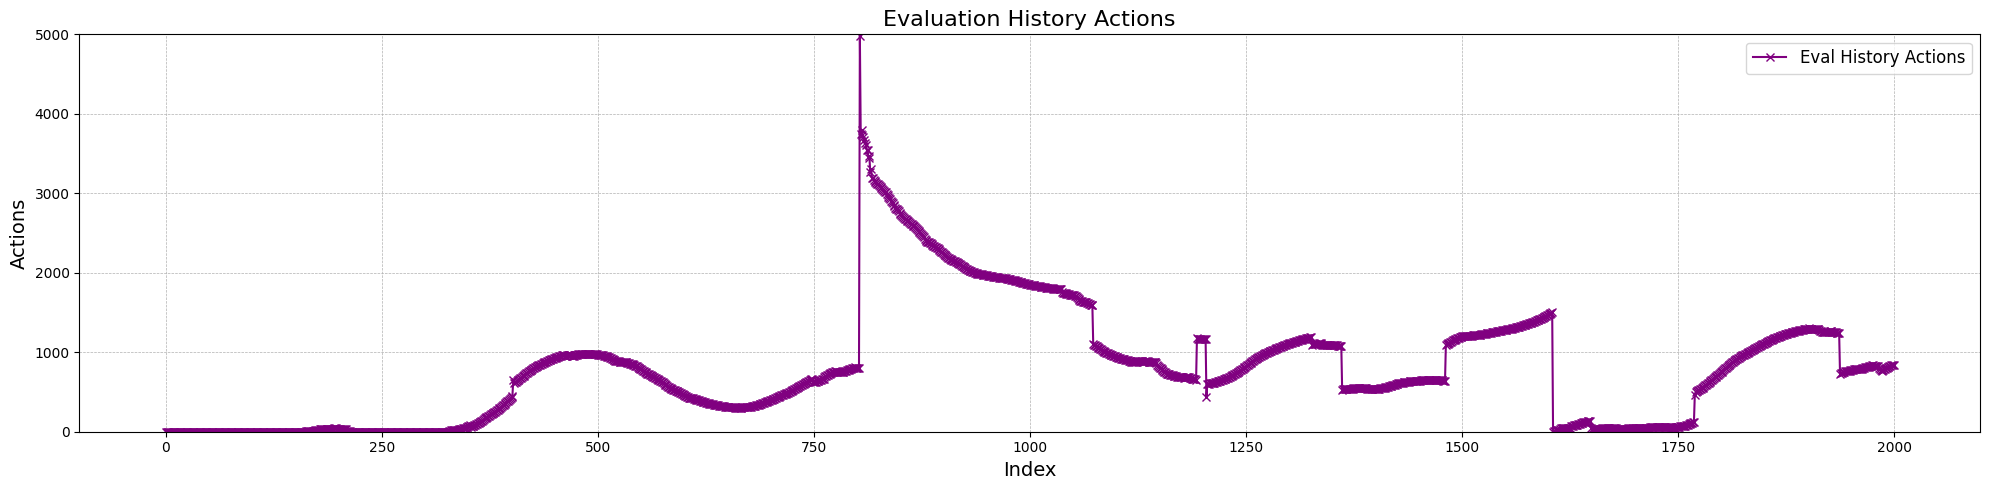

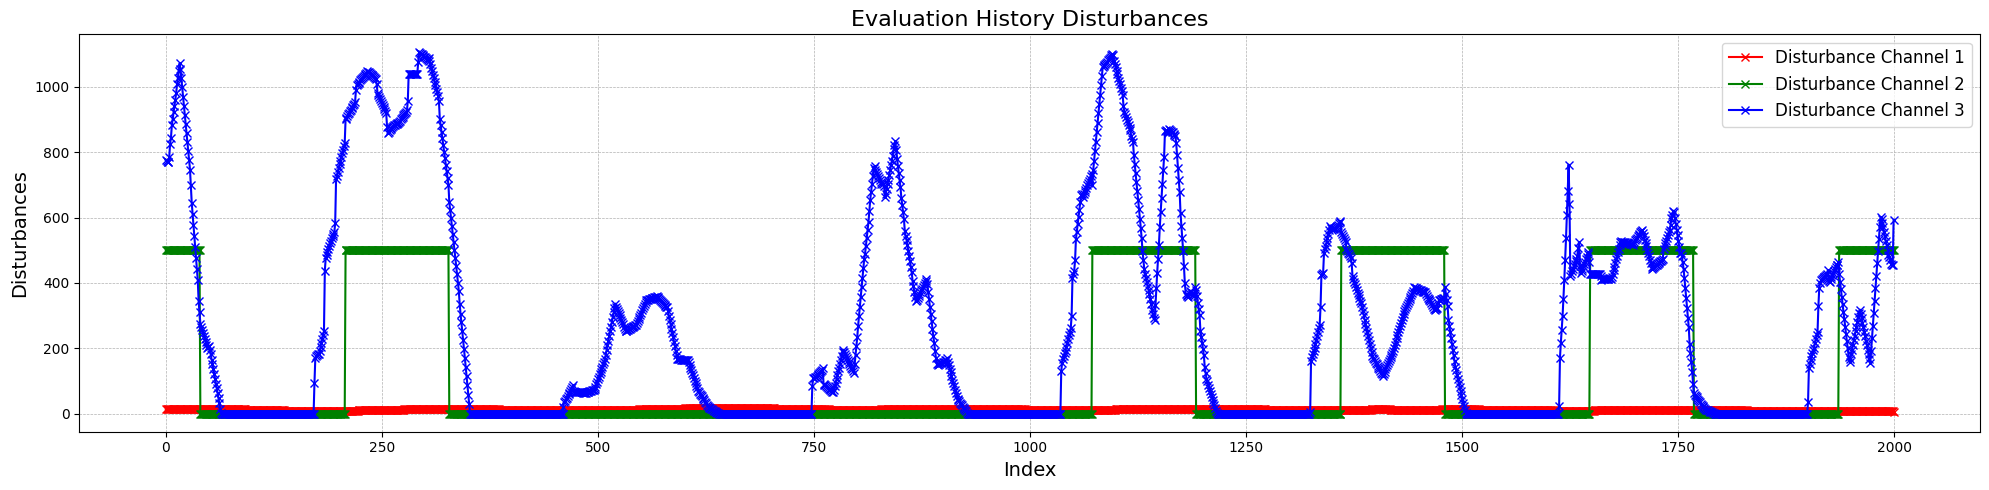

In [163]:
outputs, eval_rewards, eval_costs, eval_actions = evaluate_consecutive_episodes(eval_env, agent, horizon, min_temp, max_temp, random_seed=10)
